<a href="https://colab.research.google.com/github/leandrocino/KOA/blob/master/Copia_de_Jupyter_base_FI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar la data y preprocesarla.



In [ ]:
"""Con esto montan el drive al colab."""
from google.colab import drive
drive.mount('/content/drive/')



Mounted at /content/drive/


In [ ]:
path = '/content/drive/MyDrive/Data_koa/Old_Data_with_Kaggle_Format'
path_train = '/content/drive/MyDrive/Data_koa/Old_Data_with_Kaggle_Format/train'
path_validation = '/content/drive/MyDrive/Data_koa/val'
path_test = '/content/drive/MyDrive/Data_koa/Old_Data_with_Kaggle_Format/test'

## Variables.


In [ ]:
""" Seleccionar la cantidad de imagenes que se quieren cargar"""
n_img = 50
""" Seleccionar el tamaño de los batches"""
batch_size = 64
"""Tamaño de img"""
height = 224
width = 224
"""Generador de aleatoreidad"""
seed = None
"""Guardar imagenes transformadas"""
save_to_dir = None
"""Preprocesado """
preprocessing_function = None

## Codigo Keras preoprocessing image generator


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

image_generator = ImageDataGenerator(rescale=1./255,    
                                     preprocessing_function = None)

image_generator_augmented = ImageDataGenerator(rescale=1./255, 
                                               horizontal_flip = True, 
                                               vertical_flip= True,
                                               zoom_range=0.2,
                                               preprocessing_function = None
                                               )

train_dataset = image_generator_augmented.flow_from_directory(batch_size=batch_size,
                                                    directory=path_train,
                                                    shuffle=False,
                                                    seed=seed,
                                                    target_size=(width, height), 
                                                    #subset="training",
                                                    class_mode='categorical')

test_dataset = image_generator.flow_from_directory(batch_size=batch_size,
                                                 directory=path_test,
                                                 shuffle=False,
                                                 seed=seed,
                                                 target_size=(width, height), 
                                                 #subset="validation",
                                                 class_mode='categorical')

validation_dataset = image_generator.flow_from_directory(batch_size=batch_size,
                                                 directory=path_validation,
                                                 shuffle=False,
                                                 seed=seed,
                                                 target_size=( width, height), 
                                                 #subset="validation",
                                                 class_mode='categorical')



Found 5788 images belonging to 5 classes.
Found 1656 images belonging to 5 classes.
Found 686 images belonging to 5 classes.


In [ ]:
len(train_dataset) # tengo X=91 batches de 64 imagenes

91

In [ ]:
len(train_dataset[0])
#train_dataset[0][1]

2

In [ ]:
train_dataset[0][0].shape #accedo al primer batch, que tiene  64 imagenes,

(64, 224, 224, 3)

In [ ]:
train_dataset[0][0][0].shape

(224, 224, 3)

In [ ]:
train_dataset[0][0][0] #tenemos mal escalados los valores

array([[[0.18039216, 0.18039216, 0.18039216],
        [0.18039216, 0.18039216, 0.18039216],
        [0.18328428, 0.18328428, 0.18328428],
        ...,
        [0.35342154, 0.35342154, 0.35342154],
        [0.34901962, 0.34901962, 0.34901962],
        [0.34696072, 0.34696072, 0.34696072]],

       [[0.18039216, 0.18039216, 0.18039216],
        [0.18039216, 0.18039216, 0.18039216],
        [0.18328428, 0.18328428, 0.18328428],
        ...,
        [0.35342154, 0.35342154, 0.35342154],
        [0.34901962, 0.34901962, 0.34901962],
        [0.34696072, 0.34696072, 0.34696072]],

       [[0.18039216, 0.18039216, 0.18039216],
        [0.18039216, 0.18039216, 0.18039216],
        [0.18328428, 0.18328428, 0.18328428],
        ...,
        [0.35342154, 0.35342154, 0.35342154],
        [0.34901962, 0.34901962, 0.34901962],
        [0.34696072, 0.34696072, 0.34696072]],

       ...,

       [[0.39966172, 0.39966172, 0.39966172],
        [0.4064754 , 0.4064754 , 0.4064754 ],
        [0.40784317, 0

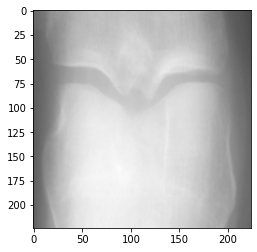

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset[0][0][22])

# Instanciar el modelo.

##    Variables.


In [ ]:
model = 'DenseNet201'
epoch = 100


## Modelo

In [ ]:
"""Transfer Learning"""

from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers, models, metrics
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping

#classes: optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified.
#classifier_activation: A str or callable. The activation function to use on the "top" layer. Ignored unless include_top=True. 
#Set classifier_activation=None to return the logits of the "top" layer. When loading pretrained weights, classifier_activation can only be None or "softmax".


def load_model():
    base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(width, height,3), pooling=None)
  
    
    base_model.trainable=False
    
    """Additional layers"""
    flattening_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(5, activation='softmax')
    convolution_layer = layers.Conv2D(500, (3,3), activation="relu")
    #pooling_layer = layers.MaxPool2D(pool_size=(2,2))
    convolution_layer_2 = layers.Conv2D(500, (2,2), activation="relu")
    pooling_layer_2 = layers.MaxPool2D(pool_size=(3,3))

    
    model = Sequential([
    base_model,
    convolution_layer,
    #pooling_layer,
    convolution_layer_2,
    flattening_layer,
    dense_layer,
    prediction_layer
    ])
    
    """Model Compile"""

    model.compile(loss='categorical_crossentropy',
                  optimizer='adamax', #no olvidarse de probar tambien ADAM
                  metrics=['accuracy']  #probar luego instanciar antes la metrica y usarla aca en variable
                  )
    
    return model

In [ ]:
model = load_model()

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 conv2d_100 (Conv2D)         (None, 5, 5, 500)         8640500   
                                                                 
 conv2d_101 (Conv2D)         (None, 4, 4, 500)         1000500   
                                                                 
 flatten_3 (Flatten)         (None, 8000)              0         
                                                                 
 dense_6 (Dense)             (None, 500)               4000500   
                                                                 
 dense_7 (Dense)             (None, 5)                 2505      
                                                                 
Total params: 31,965,989
Trainable params: 13,644,005


In [ ]:
"""Model Fit"""
Es = EarlyStopping(patience=30, restore_best_weights=True)
model_history = model.fit(train_dataset, 
                    validation_data = validation_dataset,
                    epochs=epoch, 
                    verbose=1,
                    callbacks=[Es]
                    )

Epoch 1/100
91/91 [==============================] - 822s 9s/step - loss: 3.9862 - accuracy: 0.3697 - val_loss: 1.4856 - val_accuracy: 0.2915
Epoch 2/100
91/91 [==============================] - 81s 886ms/step - loss: 1.4216 - accuracy: 0.3545 - val_loss: 1.4566 - val_accuracy: 0.3047
Epoch 3/100
91/91 [==============================] - 80s 879ms/step - loss: 1.3883 - accuracy: 0.4178 - val_loss: 1.4911 - val_accuracy: 0.2915
Epoch 4/100
91/91 [==============================] - 81s 886ms/step - loss: 1.3777 - accuracy: 0.4252 - val_loss: 1.4654 - val_accuracy: 0.3207
Epoch 5/100
91/91 [==============================] - 82s 894ms/step - loss: 1.3110 - accuracy: 0.4319 - val_loss: 1.3156 - val_accuracy: 0.3980
Epoch 6/100
91/91 [==============================] - 81s 887ms/step - loss: 1.3210 - accuracy: 0.4103 - val_loss: 1.4372 - val_accuracy: 0.3411
Epoch 7/100
91/91 [==============================] - 81s 889ms/step - loss: 1.3633 - accuracy: 0.4036 - val_loss: 1.3204 - val_accuracy: 0

In [ ]:
import matplotlib.pyplot as plt

#metrics=['accuracy', metrics.Recall(), metrics.AUC()

def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

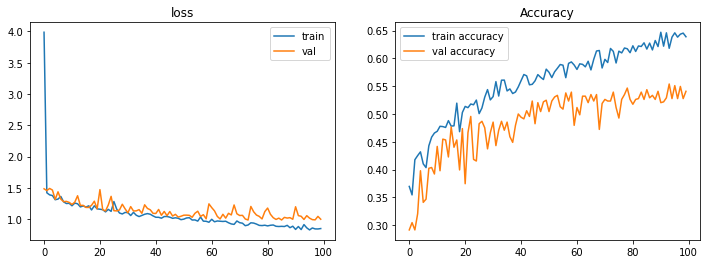

In [ ]:
plot_history(model_history, title='');

EVALUATE

In [ ]:
model.evaluate(test_dataset, verbose=1)

14/14 [==============================] - 4s 237ms/step - loss: 1.3125 - accuracy: 0.3631


[1.3125256299972534, 0.3631022274494171]

In [ ]:
pred = model.predict(test_dataset)
pred

array([[4.7623825e-01, 3.7183926e-01, 1.2902658e-01, 2.2796985e-02,
        9.8950528e-05],
       [4.4657272e-01, 3.7836549e-01, 1.4475392e-01, 3.0155139e-02,
        1.5276448e-04],
       [2.4709417e-01, 3.1352007e-01, 2.5830689e-01, 1.6144338e-01,
        1.9635543e-02],
       ...,
       [3.1863442e-03, 5.0956840e-03, 2.4009891e-02, 9.6740723e-02,
        8.7096733e-01],
       [3.6631380e-03, 6.3513685e-03, 2.7098635e-02, 1.2106185e-01,
        8.4182501e-01],
       [1.3765610e-04, 5.5633549e-04, 9.1513349e-03, 1.7043100e-01,
        8.1972367e-01]], dtype=float32)

In [ ]:
y_pred = pred.argmax(axis=1)

y_true = test_dataset.labels

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.83      0.73       639
           1       0.20      0.01      0.03       296
           2       0.52      0.66      0.59       447
           3       0.75      0.70      0.73       223
           4       0.75      0.71      0.73        51

    accuracy                           0.62      1656
   macro avg       0.58      0.58      0.56      1656
weighted avg       0.55      0.62      0.56      1656



https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

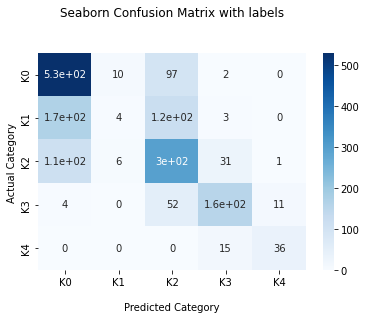

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['K0','K1', 'K2', 'K3', 'K4'])
ax.yaxis.set_ticklabels(['K0','K1', 'K2', 'K3', 'K4'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
import joblib
joblib_file = "modelo_lindo.joblib"  
joblib.dump(model, joblib_file)

INFO:tensorflow:Assets written to: ram://1220a91f-9bf2-4c42-9c9d-893a204bca94/assets


['modelo_lindo.joblib']

In [ ]:
!pwd

/content


In [ ]:
!ls -lh

total 243M
drwx------ 5 root root 4.0K Jan 22 10:37 drive
-rw-r--r-- 1 root root 243M Jan 22 16:38 modelo_lindo.joblib
drwxr-xr-x 1 root root 4.0K Jan  7 14:33 sample_data
